# **Data**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.utils import pad_sequences,plot_model
from sklearn import model_selection
from sklearn.metrics import classification_report,confusion_matrix
from string import printable
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Model,load_model
from keras import regularizers
from keras.layers import Dense, Dropout, Activation, Lambda, Flatten
from keras.layers import Input, ELU, LSTM, Embedding, BatchNormalization, Conv1D, MaxPooling1D,GRU,SimpleRNN
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [2]:
import tensorboard
from datetime import datetime
from packaging import version

In [3]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [4]:
df=pd.read_csv('phishing_site_urls.csv')

In [5]:
df.shape

(549346, 2)

In [6]:
df['URL'][1]

'www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php'

In [7]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

In [8]:
df['Label'].value_counts()

Label
good    392924
bad     156422
Name: count, dtype: int64

C:\Users\Aaditya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aaditya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aaditya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Label', ylabel='count'>

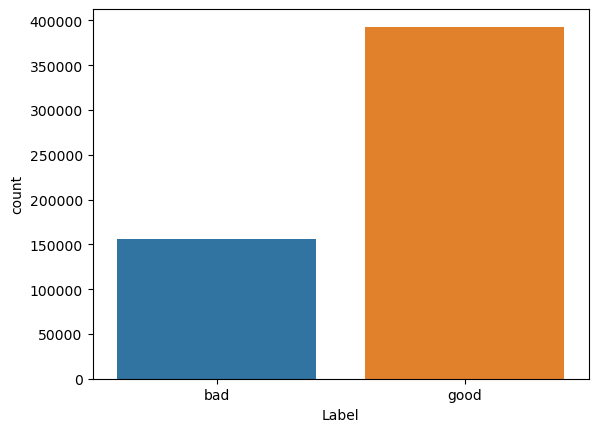

In [9]:
sns.countplot(x='Label', data=df)

In [10]:
df.loc[df["Label"] == 'bad', "Label"] = 0
df.loc[df["Label"] == "good", "Label"] = 1
df.Label.value_counts()

Label
1    392924
0    156422
Name: count, dtype: int64

In [11]:
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,0
3,mail.printakid.com/www.online.americanexpress....,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,0


# example preprocessing

In [12]:
character_encoding=[printable.index(x) + 1 for x in printable]
for x in range(0,len(character_encoding)):
  print(printable[x],"=",character_encoding[x],"\n")

0 = 1 

1 = 2 

2 = 3 

3 = 4 

4 = 5 

5 = 6 

6 = 7 

7 = 8 

8 = 9 

9 = 10 

a = 11 

b = 12 

c = 13 

d = 14 

e = 15 

f = 16 

g = 17 

h = 18 

i = 19 

j = 20 

k = 21 

l = 22 

m = 23 

n = 24 

o = 25 

p = 26 

q = 27 

r = 28 

s = 29 

t = 30 

u = 31 

v = 32 

w = 33 

x = 34 

y = 35 

z = 36 

A = 37 

B = 38 

C = 39 

D = 40 

E = 41 

F = 42 

G = 43 

H = 44 

I = 45 

J = 46 

K = 47 

L = 48 

M = 49 

N = 50 

O = 51 

P = 52 

Q = 53 

R = 54 

S = 55 

T = 56 

U = 57 

V = 58 

W = 59 

X = 60 

Y = 61 

Z = 62 

! = 63 

" = 64 

# = 65 

$ = 66 

% = 67 

& = 68 

' = 69 

( = 70 

) = 71 

* = 72 

+ = 73 

, = 74 

- = 75 

. = 76 

/ = 77 

: = 78 

; = 79 

< = 80 

= = 81 

> = 82 

? = 83 

@ = 84 

[ = 85 

\ = 86 

] = 87 

^ = 88 

_ = 89 

` = 90 

{ = 91 

| = 92 

} = 93 

~ = 94 

  = 95 

	 = 96 


 = 97 

 = 98 

 = 99 

 = 100 



In [13]:
url='https://www.apple.com/'
encoded=[printable.index(x) + 1 for x in url if x in printable]
print(encoded)

[18, 30, 30, 26, 29, 78, 77, 77, 33, 33, 33, 76, 11, 26, 26, 22, 15, 76, 13, 25, 23, 77]


# **Pre-processing**

In [14]:
#1) encoding the characters in URL from 1 to 100, using nested list comprehension.
url_encoded = [[printable.index(x) + 1 for x in url if x in printable] for url in df.URL]

In [15]:
#2)Length normalization, The length of all URL's normalized at fixed length, if the (url length< fixed length) zeroes are added at front of the url,
# if the (url length> fixed length) the etra character are intercepted from the end
max_len=75
X = pad_sequences(url_encoded, maxlen=max_len, truncating='post')

In [16]:
X.shape

(549346, 75)

In [17]:
X

array([[24, 25, 12, ..., 77, 32, 15],
       [33, 33, 33, ..., 11, 14, 19],
       [29, 15, 28, ...,  4,  3,  2],
       ...,
       [ 0,  0,  0, ..., 28, 17, 77],
       [ 0,  0,  0, ..., 28, 17, 77],
       [ 0,  0,  0, ..., 24, 16, 25]])

In [18]:
y = np.array(df.Label)

In [19]:
y.shape

(549346,)

# **Splitting-data**

In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=33)
X_test, X_val, y_test, y_val = model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [21]:
model = tf.keras.Sequential()
model.add(layers.LSTM(64, input_shape=(75,1)))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer = 'adam', metrics=['accuracy'])

In [23]:
X_train = np.asarray(X_train).astype(np.float32)
X_val = np.asarray(X_val).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [25]:
epochs = 10
batch_size = 32

his1=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,y_val), callbacks=[tensorboard_callback])

Epoch 1/10
13734/13734 [==============================] - 556s 40ms/step - loss: 0.4125 - accuracy: 0.8157 - val_loss: 0.3074 - val_accuracy: 0.8713
Epoch 2/10
13734/13734 [==============================] - 544s 40ms/step - loss: 0.2707 - accuracy: 0.8895 - val_loss: 0.2525 - val_accuracy: 0.8962
Epoch 3/10
13734/13734 [==============================] - 544s 40ms/step - loss: 0.2326 - accuracy: 0.9071 - val_loss: 0.2275 - val_accuracy: 0.9098
Epoch 4/10
13734/13734 [==============================] - 555s 40ms/step - loss: 0.2127 - accuracy: 0.9162 - val_loss: 0.2090 - val_accuracy: 0.9172
Epoch 5/10
13734/13734 [==============================] - 533s 39ms/step - loss: 0.1986 - accuracy: 0.9223 - val_loss: 0.2013 - val_accuracy: 0.9207
Epoch 6/10
13734/13734 [==============================] - 533s 39ms/step - loss: 0.1877 - accuracy: 0.9269 - val_loss: 0.1918 - val_accuracy: 0.9252
Epoch 7/10
13734/13734 [==============================] - 599s 44ms/step - loss: 0.1828 - accuracy: 0.9290

In [26]:
model.save('Mini_Proj_LSTM.keras')

In [27]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print('\nValidation Accuracy', test_accuracy, '\n')

1717/1717 [==============================] - 33s 19ms/step - loss: 0.1744 - accuracy: 0.9321

Validation Accuracy 0.9320833683013916 



In [28]:
predictions=model.predict(X_test)

1717/1717 [==============================] - 37s 21ms/step


In [29]:
predictions = (predictions>=0.5).astype(int)

In [35]:
predictions.shape

(54935, 1)

In [30]:
cm=confusion_matrix(y_test,predictions)
cm

array([[13615,  2044],
       [ 1687, 37589]], dtype=int64)

In [ ]:
predictions.shape

(7127,)

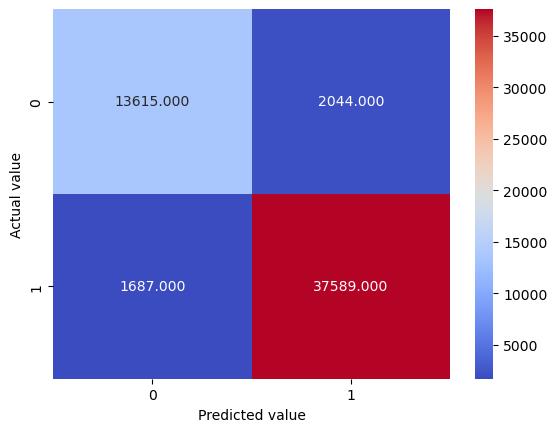

In [31]:
sns.heatmap(cm, annot=True, cmap='coolwarm',fmt='0.3f')
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

In [32]:
accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
accuracy

0.9320833712569401

In [33]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88     15659
         1.0       0.95      0.96      0.95     39276

    accuracy                           0.93     54935
   macro avg       0.92      0.91      0.92     54935
weighted avg       0.93      0.93      0.93     54935



In [34]:
h1=his1.history
h1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

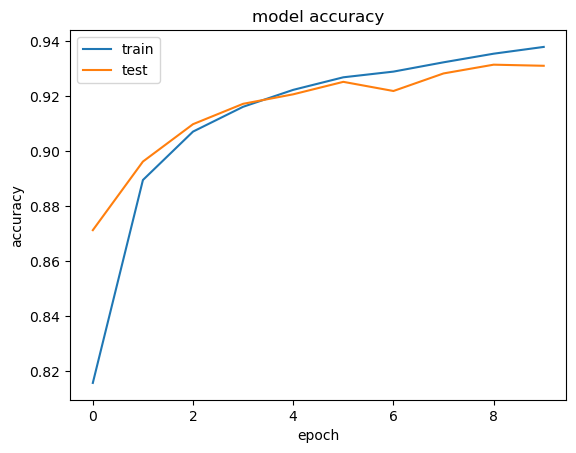

In [35]:
# summarize history for accuracy
plt.plot(h1['accuracy'])
plt.plot(h1['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

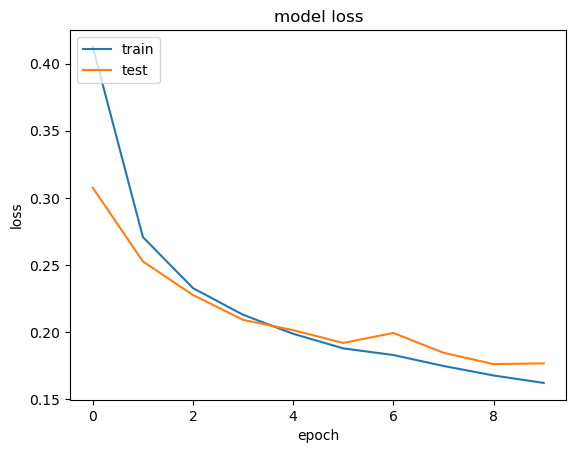

In [36]:
# summarize history for loss
plt.plot(h1['loss'])
plt.plot(h1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ***TESTING***

In [37]:
def output_gru(url):
  gru_model=load_model("Mini_Proj.keras")
  encoded_url=[[printable.index(x) + 1 for x in url if x in printable]]
  max_len=75
  preprocessed_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')
  return np.argmax(gru_model.predict(preprocessed_url,batch_size=1)),gru_model.predict(preprocessed_url,batch_size=1)

In [38]:
# Took a random website link from Phishtank which has all phishing links
output_gru('enterspages.com/QC/St-Leonard-apartment.html')

1/1 [==============================] - 0s 24ms/step


(0, array([[1.]], dtype=float32))

In [39]:
cnn_gru_model=load_model("Mini_Proj_LSTM.keras")

In [40]:
cnn_gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
cnn_gru_model.evaluate(X_train,y_train,verbose=1)

13734/13734 [==============================] - 200s 14ms/step - loss: 0.1577 - accuracy: 0.9401


[0.15771959722042084, 0.9401378035545349]

In [46]:
test_url='https:\\www.google.com'
encoded_url=[[printable.index(x) + 1 for x in test_url if x in printable]]
max_len=75
encoded_url = np.asarray(encoded_url).astype(np.float32)
encoded_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')
cnn_gru_model.predict(encoded_url,batch_size=1)

1/1 [==============================] - 0s 48ms/step


array([[0.87177384]], dtype=float32)

In [45]:
test_url='nobell.it/70ffb52d079109dca5664cce6f317373782/'
encoded_url=[[printable.index(x) + 1 for x in test_url if x in printable]]
max_len=75
encoded_url = np.asarray(encoded_url).astype(np.float32)
encoded_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')
cnn_gru_model.predict(encoded_url,batch_size=1)

1/1 [==============================] - 0s 35ms/step


array([[0.25908574]], dtype=float32)

In [47]:
test_url='www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php'
encoded_url=[[printable.index(x) + 1 for x in test_url if x in printable]]
max_len=75
encoded_url = np.asarray(encoded_url).astype(np.float32)
encoded_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')
cnn_gru_model.predict(encoded_url,batch_size=1)

1/1 [==============================] - 0s 44ms/step


array([[0.4488583]], dtype=float32)

In [48]:
test_url='www.paypal.co.in'
encoded_url=[[printable.index(x) + 1 for x in test_url if x in printable]]
max_len=75
encoded_url = np.asarray(encoded_url).astype(np.float32)
encoded_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')
cnn_gru_model.predict(encoded_url,batch_size=1)

1/1 [==============================] - 0s 35ms/step


array([[0.8861712]], dtype=float32)